In [210]:
import numpy as np
import librosa as lb
import soundfile as sf
from matplotlib import pyplot as plt
from tqdm import tqdm
import museval

In [186]:
bleed_path = '/home/rajesh/Desktop/Datasets/musdb18hq_bleeded/train/Music Delta - Hendrix/'
bvocals, fs = lb.load(bleed_path+'vocals.wav')
bbass, fs = lb.load(bleed_path+'bass.wav')
bdrums, fs = lb.load(bleed_path+'drums.wav')
bother, fs = lb.load(bleed_path+'other.wav')

In [187]:
clean_path = '/home/rajesh/Desktop/Datasets/musdb18hq/train/Music Delta - Hendrix/'
vocals, fs = lb.load(clean_path+'vocals.wav')
bass, fs = lb.load(clean_path+'bass.wav')
drums, fs = lb.load(clean_path+'drums.wav')
other, fs = lb.load(clean_path+'other.wav')

In [190]:
if len(bbass) > len(bass):
    n = len(bass)
else:
    n = len(bbass)

In [191]:
R = np.array([bvocals[:n], bbass[:n], bdrums[:n], bother[:n]]) #two min
R.shape

(4, 437559)

In [192]:
S = np.array([vocals[:n], bass[:n], drums[:n], other[:n]])
S.shape

(4, 437559)

In [277]:
import numpy as np

def vector_factorisation(x, gamma1, gamma2, max_iter=1000, tol=1e-50):
    n = len(x)
    s = np.copy(x)
    A = np.eye(n)
    epsilon = 1e-10

    for i in range(max_iter):
        # update A
        for j in range(n):
            A[j, j] = 1  # diagonal elements
            for k in range(n):
                if k != j:
                    num = x[j] * s[k] - np.dot(A[k], s) + A[j, k] * s[j] * s[k]
                    A[j, k] = max(gamma1, min(gamma2, num / (s[j]+epsilon)))

        # update s
        s = np.linalg.lstsq(A, x, rcond=None)[0]

        # calculate error
        error = np.linalg.norm(x - np.dot(A, s)) ** 2

        if i > 0 and abs(error - prev_error) < tol:
            break

        prev_error = error

    return A, s


In [298]:
x = np.array([-3.9729321e-07,  3.2556574e-05, -2.3602612e-05,  4.4392395e-06])
gamma1 = -0.13331029356045582
gamma2 = 0.10644719
A, s = vector_factorisation(x, gamma1, gamma2)
error = np.linalg.norm(x - np.dot(A, s)) ** 2
x, A, s, error,np.dot(A, s), i

(array([-3.9729321e-07,  3.2556574e-05, -2.3602612e-05,  4.4392395e-06]),
 array([[ 1.        ,  0.10644719, -0.13331029,  0.10644719],
        [ 0.01064937,  1.        ,  0.10644719, -0.11907814],
        [-0.01367706,  0.10644719,  1.        ,  0.10644719],
        [ 0.03103351, -0.13331029,  0.10644719,  1.        ]]),
 array([-9.60249550e-06,  3.72769306e-05, -2.90645451e-05,  1.28004763e-05]),
 1.4131618571237911e-39,
 array([-3.9729321e-07,  3.2556574e-05, -2.3602612e-05,  4.4392395e-06]),
 0)

In [280]:
S[:,0]

array([ 5.7915386e-06,  3.8102819e-05, -2.8182852e-05,  1.2415013e-05],
      dtype=float32)

In [281]:
R[:,0]

array([-3.9729321e-07,  3.2556574e-05, -2.3602612e-05,  4.4392395e-06],
      dtype=float32)

In [287]:
def leastnormsoln(r, s):
    b = np.array([r-s]).T
    A = np.array([[s[1], s[2], s[3], 0, 0 ,0, 0, 0, 0, 0, 0, 0], 
                  [0, 0, 0, s[0], s[2], s[3], 0, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 0, 0, 0, s[0], s[1], s[3], 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, s[0], s[1], s[2]]])
    soln, residual, rank, singular = np.linalg.lstsq(A, b, rcond=-1)
    return np.array([[1, soln[0][0], soln[1][0], soln[2][0]],
                     [soln[3][0], 1, soln[4][0], soln[5][0]],
                     [soln[6][0], soln[7][0], 1, soln[8][0]],
                     [soln[9][0], soln[10][0], soln[11][0], 1]])

In [288]:
def norm(A):
    forb = np.linalg.norm(A, ord='fro')
    l1 = np.linalg.norm(A, ord=1)
    return l1, forb

In [291]:
A = leastnormsoln(R[:,0], S[:,0])
A

array([[ 1.        , -0.09824554,  0.07266758, -0.03201127],
       [-0.03271181,  1.        ,  0.1591826 , -0.07012257],
       [ 0.01617972,  0.10644719,  1.        ,  0.03468361],
       [-0.02026285, -0.13331029,  0.09860332,  1.        ]])

In [300]:
A_dash = np.array([[ 1.        ,  0.10644719, -0.13331029,  0.10644719],
        [ 0.01064937,  1.        ,  0.10644719, -0.11907814],
        [-0.01367706,  0.10644719,  1.        ,  0.10644719],
        [ 0.03103351, -0.13331029,  0.10644719,  1.        ]])

In [302]:
l1, forb = norm(A-A_dash)
l1, forb

(1.095374643073077e-08, 8.648627158193877e-09)

In [308]:
np.min(A)

-0.13331029356045582

In [268]:
s_cap = []
lmbda = []
for i in tqdm(range(R.shape[1])):
    gamma1 = 0
    gamma2 = 0.5
    A, s = vector_factorisation(R[:,i], gamma1, gamma2)
    s_cap.append(s)
    lmbda.append(A)

  0%|                                                                                                            | 0/437559 [00:00<?, ?it/s]


TypeError: vector_factorisation() missing 1 required positional argument: 'gamma2'

In [254]:
s_cap = np.array(s_cap)
spred = s_cap.T

In [255]:
spred.shape

(4, 437559)

In [256]:
out = '/home/rajesh/Desktop/'
sf.write(out+'pred_vocal.wav', spred[0], fs)
sf.write(out+'pred_bass.wav', spred[1], fs)
sf.write(out+'pred_drums.wav', spred[2], fs)
sf.write(out+'pred_other.wav', spred[3], fs)

In [257]:
def get_metrics(y):
    avg_y = []
    for i in range(len(y)):
        x = y[~np.isnan(y)]
        avg = sum(x)/len(x)
        avg_y.append(avg)
    return avg_y

In [258]:
def compute_sdr(true, reconstructed, fs):
    t = np.array([true])
    r = np.array([reconstructed])

    sdr, isr, sir, sar = museval.evaluate(t, r, win=fs, hop=fs)
        
    avg_sdr = get_metrics(sdr)
    avg_isr = get_metrics(isr) #Source to Spatial Distortion Image
    avg_sir = get_metrics(sir)
    avg_sar = get_metrics(sar)

    return sum(avg_sdr)/len(avg_sdr)

In [259]:
v_sdr = compute_sdr(vocals[:n], spred[0], fs)
b_sdr = compute_sdr(bass[:n], spred[1], fs)
d_sdr = compute_sdr(drums[:n], spred[2], fs)
o_sdr = compute_sdr(other[:n], spred[3], fs)

sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
sdr, v_sdr, b_sdr, d_sdr, o_sdr

(-8.364896684416284,
 -10.004847846324298,
 -7.028044510176757,
 -5.511595098366152,
 -10.915099282797922)

In [260]:
lmbda[0], lmbda[1], lmbda[3]

(array([[ 1.        ,  0.4       , -0.4       ,  0.09242999],
        [ 0.00694033,  1.        ,  0.4       , -0.07783571],
        [-0.00781668,  0.4       ,  1.        ,  0.08712342],
        [ 0.00826686, -0.4       ,  0.4       ,  1.        ]]),
 array([[ 1.        ,  0.22206637,  0.4       , -0.31354435],
        [-0.10919454,  1.        , -0.4       ,  0.24847563],
        [-0.11315258, -0.4       ,  1.        ,  0.25739494],
        [ 0.1165913 ,  0.4       ,  0.4       ,  1.        ]]),
 array([[ 1.        , -0.22776837, -0.4       , -0.32246864],
        [ 0.06611228,  1.        , -0.4       , -0.24260993],
        [ 0.06355275, -0.4       ,  1.        , -0.23197225],
        [ 0.1235702 , -0.4       , -0.4       ,  1.        ]]))

In [261]:
R[:,0]

array([-3.9729321e-07,  3.2556574e-05, -2.3602612e-05,  4.4392395e-06],
      dtype=float32)

In [262]:
np.dot(lmbda[0], S[:, 0])

array([ 3.34533265e-05,  2.59035414e-05, -1.19053573e-05, -1.40513777e-05])

In [265]:
error = np.linalg.norm(R[:,2] - np.dot(lmbda[2], S[:, 2])) ** 2
error

5.08848937408005e-08

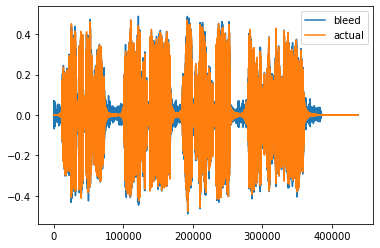

In [312]:
plt.plot(bvocals)
plt.plot(vocals)
plt.legend(['bleed', 'actual'])
plt.show()

In [319]:
x = np.array([0, 0, 0, -1.1138899e-04])
gamma1 = -0.13331029356045582
gamma2 = 0.10644719
A, s = vector_factorisation(x, gamma1, gamma2)
error = np.linalg.norm(x - np.dot(A, s)) ** 2
x, A, s, error,np.dot(A, s), i

(array([ 0.        ,  0.        ,  0.        , -0.00011139]),
 array([[ 1.00000000e+00, -3.85757677e-15, -1.42877543e-16,
          1.06447190e-01],
        [ 3.00032676e-15,  1.00000000e+00, -1.42877543e-16,
          1.06447190e-01],
        [ 3.00032676e-15, -6.71499549e-15,  1.00000000e+00,
          1.06447190e-01],
        [ 1.18571962e-05,  1.18571962e-05,  1.18571962e-05,
          1.00000000e+00]]),
 array([ 1.18570899e-05,  1.18570899e-05,  1.18570899e-05, -1.11389412e-04]),
 1.720196057734855e-38,
 array([ 6.77626358e-21, -4.23519331e-20, -2.20228566e-20, -1.11388990e-04]),
 0)

In [318]:
R[:, 429975], S[:, 429975]

(array([-6.1166305e-05, -6.1750339e-05, -5.5832737e-05, -1.1138899e-04],
       dtype=float32),
 array([-1.4143027e-05, -1.6101958e-05,  2.8558563e-06, -8.4536310e-05],
       dtype=float32))

In [315]:
19.5*fs

429975.0